# SwellSight Model Architecture (Standalone)

This notebook defines the SwellSight multi-task neural network architecture for wave analysis.
**This is a standalone version that includes all necessary code and doesn't require external files.**

## Overview
- **Backbone**: EfficientNet-B0 with pretrained weights
- **Tasks**: Wave height (regression), wave type (classification), direction (classification)
- **Architecture**: Shared feature extractor with task-specific heads

In [1]:
# Install required packages if not available
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install required packages
install_if_missing("torch")
install_if_missing("torchvision")
install_if_missing("matplotlib")
install_if_missing("numpy")

print("✓ All required packages are available")

✓ All required packages are available


In [2]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import matplotlib.pyplot as plt
import numpy as np

# Try to import torchsummary, install if not available
try:
    from torchsummary import summary
    HAS_TORCHSUMMARY = True
except ImportError:
    print("torchsummary not found. Install with: pip install torchsummary")
    HAS_TORCHSUMMARY = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

torchsummary not found. Install with: pip install torchsummary
PyTorch version: 2.9.1
CUDA available: False


## SwellSight Model Definition

In [3]:
class SwellSightNet(nn.Module):
    """SwellSight multi-task neural network for wave analysis.
    
    Predicts:
    - Wave height (regression)
    - Wave type (classification)
    - Wave direction (classification)
    """
    
    def __init__(self, num_wave_types: int, num_directions: int, dropout: float = 0.35):
        super().__init__()

        # Load pretrained EfficientNet-B0 backbone
        weights = EfficientNet_B0_Weights.DEFAULT
        self.backbone = efficientnet_b0(weights=weights)

        # Get feature dimension and replace classifier
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # Shared feature processing
        self.shared = nn.Sequential(
            nn.LayerNorm(in_features),
            nn.Dropout(dropout),
        )

        # Task-specific heads
        self.head_height = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, 1)  # Single output for height regression
        )

        self.head_wave_type = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_wave_types)  # Classification outputs
        )

        self.head_direction = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_directions)  # Classification outputs
        )

    def forward(self, x):
        """Forward pass through the network.
        
        Args:
            x: Input tensor of shape (batch_size, 3, height, width)
            
        Returns:
            Tuple of (height_pred, wave_type_logits, direction_logits)
        """
        # Extract features using backbone
        feats = self.backbone(x)
        
        # Apply shared processing
        feats = self.shared(feats)
        
        # Get predictions from each head
        height_pred = self.head_height(feats)
        wave_type_logits = self.head_wave_type(feats)
        direction_logits = self.head_direction(feats)
        
        return height_pred, wave_type_logits, direction_logits

print("✓ SwellSightNet model class defined")

✓ SwellSightNet model class defined


## Model Instantiation and Testing

In [4]:
# Define wave types and directions (standard SwellSight classes)
WAVE_TYPES = ["beach_break", "reef_break", "point_break", "closeout", "a_frame"]
DIRECTIONS = ["left", "right", "both"]

print(f"Wave types ({len(WAVE_TYPES)}): {WAVE_TYPES}")
print(f"Directions ({len(DIRECTIONS)}): {DIRECTIONS}")

# Create model instance
model = SwellSightNet(len(WAVE_TYPES), len(DIRECTIONS))

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Wave types (5): ['beach_break', 'reef_break', 'point_break', 'closeout', 'a_frame']
Directions (3): ['left', 'right', 'both']

✓ Model created successfully!
Total parameters: 4,996,229
Trainable parameters: 4,996,229


In [5]:
# Test forward pass with dummy data
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Using device: {device}")

# Create dummy input batch
batch_size = 4
image_size = 224
x = torch.randn(batch_size, 3, image_size, image_size).to(device)

print(f"\nTesting forward pass...")
print(f"Input shape: {x.shape}")

# Run forward pass
model.eval()
with torch.no_grad():
    pred_h, pred_wt, pred_dir = model(x)

print(f"\n✓ Forward pass successful!")
print(f"Height prediction shape: {pred_h.shape} (expected: [{batch_size}, 1])")
print(f"Wave type prediction shape: {pred_wt.shape} (expected: [{batch_size}, {len(WAVE_TYPES)}])")
print(f"Direction prediction shape: {pred_dir.shape} (expected: [{batch_size}, {len(DIRECTIONS)}])")

# Show example predictions
print(f"\nExample predictions for first sample:")
print(f"Height: {pred_h[0].item():.3f} meters")
print(f"Wave type logits: {pred_wt[0].cpu().numpy()}")
print(f"Direction logits: {pred_dir[0].cpu().numpy()}")

Using device: cpu

Testing forward pass...
Input shape: torch.Size([4, 3, 224, 224])

✓ Forward pass successful!
Height prediction shape: torch.Size([4, 1]) (expected: [4, 1])
Wave type prediction shape: torch.Size([4, 5]) (expected: [4, 5])
Direction prediction shape: torch.Size([4, 3]) (expected: [4, 3])

Example predictions for first sample:
Height: 0.034 meters
Wave type logits: [ 0.14305647  0.0600403   0.18041639 -0.25896797  0.05498288]
Direction logits: [ 0.14979646 -0.02838653 -0.3650689 ]


## Model Architecture Visualization

In [6]:
# Visualize model architecture
if HAS_TORCHSUMMARY:
    try:
        print("Model Architecture Summary:")
        print("=" * 50)
        summary(model, (3, 224, 224))
    except Exception as e:
        print(f"Could not display model summary: {e}")
        print("\nModel structure:")
        print(model)
else:
    print("Model Structure:")
    print("=" * 50)
    print(model)
    print("\n💡 Install torchsummary for detailed summary: pip install torchsummary")

Model Structure:
SwellSightNet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
  

## Model Components Analysis

In [7]:
# Analyze model components
def analyze_model_components(model):
    """Analyze and display information about model components."""
    
    print("Model Component Analysis:")
    print("=" * 40)
    
    # Backbone analysis
    backbone_params = sum(p.numel() for p in model.backbone.parameters())
    print(f"\n🏗️  Backbone (EfficientNet-B0):")
    print(f"   Parameters: {backbone_params:,}")
    print(f"   Percentage: {backbone_params/total_params*100:.1f}%")
    
    # Shared layer analysis
    shared_params = sum(p.numel() for p in model.shared.parameters())
    print(f"\n🔗 Shared layers:")
    print(f"   Parameters: {shared_params:,}")
    print(f"   Percentage: {shared_params/total_params*100:.1f}%")
    
    # Task-specific heads
    height_params = sum(p.numel() for p in model.head_height.parameters())
    wt_params = sum(p.numel() for p in model.head_wave_type.parameters())
    dir_params = sum(p.numel() for p in model.head_direction.parameters())
    
    print(f"\n📏 Height head:")
    print(f"   Parameters: {height_params:,}")
    print(f"   Percentage: {height_params/total_params*100:.1f}%")
    
    print(f"\n🌊 Wave type head:")
    print(f"   Parameters: {wt_params:,}")
    print(f"   Percentage: {wt_params/total_params*100:.1f}%")
    
    print(f"\n🧭 Direction head:")
    print(f"   Parameters: {dir_params:,}")
    print(f"   Percentage: {dir_params/total_params*100:.1f}%")
    
    # Verify total
    component_total = backbone_params + shared_params + height_params + wt_params + dir_params
    print(f"\n✓ Component total: {component_total:,}")
    print(f"✓ Model total: {total_params:,}")
    print(f"✓ Match: {component_total == total_params}")

analyze_model_components(model)

Model Component Analysis:

🏗️  Backbone (EfficientNet-B0):
   Parameters: 4,007,548
   Percentage: 80.2%

🔗 Shared layers:
   Parameters: 2,560
   Percentage: 0.1%

📏 Height head:
   Parameters: 328,193
   Percentage: 6.6%

🌊 Wave type head:
   Parameters: 329,221
   Percentage: 6.6%

🧭 Direction head:
   Parameters: 328,707
   Percentage: 6.6%

✓ Component total: 4,996,229
✓ Model total: 4,996,229
✓ Match: True


## Prediction Interpretation

In [8]:
# Function to interpret model predictions
def interpret_predictions(height_pred, wave_type_logits, direction_logits, wave_types, directions):
    """Convert raw model outputs to interpretable predictions."""
    
    # Height is direct regression output
    height_meters = height_pred.item()
    
    # Convert logits to probabilities and get predicted classes
    wt_probs = torch.softmax(wave_type_logits, dim=0)
    dir_probs = torch.softmax(direction_logits, dim=0)
    
    wt_pred_idx = torch.argmax(wt_probs).item()
    dir_pred_idx = torch.argmax(dir_probs).item()
    
    predicted_wave_type = wave_types[wt_pred_idx]
    predicted_direction = directions[dir_pred_idx]
    
    wt_confidence = wt_probs[wt_pred_idx].item()
    dir_confidence = dir_probs[dir_pred_idx].item()
    
    return {
        'height_meters': height_meters,
        'wave_type': predicted_wave_type,
        'direction': predicted_direction,
        'wave_type_confidence': wt_confidence,
        'direction_confidence': dir_confidence,
        'wave_type_probs': {wt: prob.item() for wt, prob in zip(wave_types, wt_probs)},
        'direction_probs': {d: prob.item() for d, prob in zip(directions, dir_probs)}
    }

# Interpret the first sample's predictions
interpretation = interpret_predictions(
    pred_h[0], pred_wt[0], pred_dir[0], WAVE_TYPES, DIRECTIONS
)

print("Prediction Interpretation:")
print("=" * 30)
print(f"🌊 Wave Height: {interpretation['height_meters']:.2f} meters")
print(f"🏄 Wave Type: {interpretation['wave_type']} (confidence: {interpretation['wave_type_confidence']:.3f})")
print(f"🧭 Direction: {interpretation['direction']} (confidence: {interpretation['direction_confidence']:.3f})")

print(f"\nDetailed Wave Type Probabilities:")
for wt, prob in interpretation['wave_type_probs'].items():
    print(f"  {wt}: {prob:.3f}")

print(f"\nDetailed Direction Probabilities:")
for direction, prob in interpretation['direction_probs'].items():
    print(f"  {direction}: {prob:.3f}")

Prediction Interpretation:
🌊 Wave Height: 0.03 meters
🏄 Wave Type: point_break (confidence: 0.228)
🧭 Direction: left (confidence: 0.411)

Detailed Wave Type Probabilities:
  beach_break: 0.220
  reef_break: 0.203
  point_break: 0.228
  closeout: 0.147
  a_frame: 0.202

Detailed Direction Probabilities:
  left: 0.411
  right: 0.344
  both: 0.245


## Visualization of Predictions

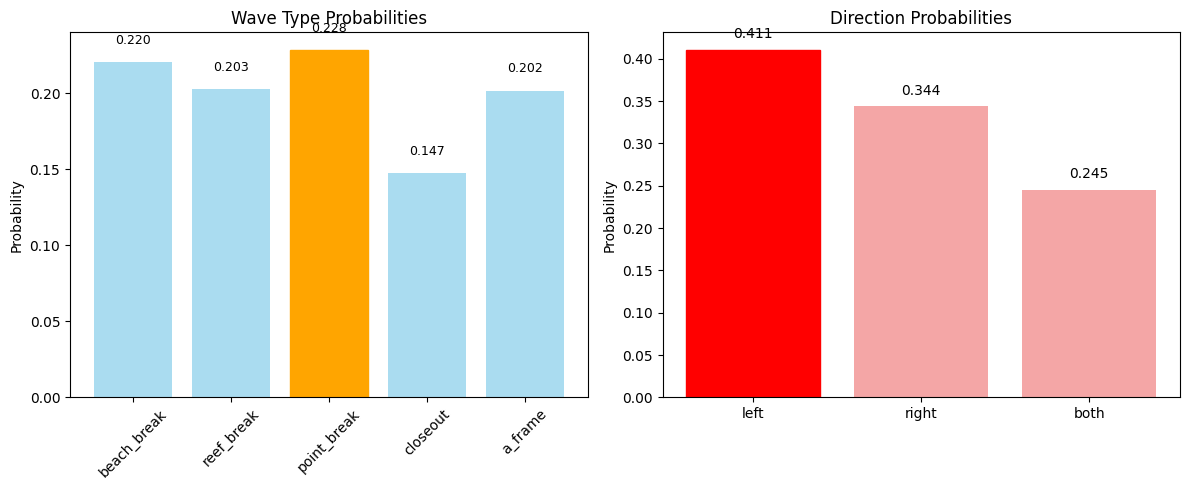


📊 Visualization shows prediction probabilities for a random input
🎯 Predicted: 0.03m point_break wave going left


In [9]:
# Visualize prediction probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Wave type probabilities
wt_names = list(interpretation['wave_type_probs'].keys())
wt_probs = list(interpretation['wave_type_probs'].values())

bars1 = ax1.bar(wt_names, wt_probs, color='skyblue', alpha=0.7)
ax1.set_title('Wave Type Probabilities')
ax1.set_ylabel('Probability')
ax1.tick_params(axis='x', rotation=45)

# Highlight predicted class
pred_idx = wt_names.index(interpretation['wave_type'])
bars1[pred_idx].set_color('orange')
bars1[pred_idx].set_alpha(1.0)

# Add values on bars
for bar, prob in zip(bars1, wt_probs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.3f}', ha='center', va='bottom', fontsize=9)

# Direction probabilities
dir_names = list(interpretation['direction_probs'].keys())
dir_probs = list(interpretation['direction_probs'].values())

bars2 = ax2.bar(dir_names, dir_probs, color='lightcoral', alpha=0.7)
ax2.set_title('Direction Probabilities')
ax2.set_ylabel('Probability')

# Highlight predicted class
pred_idx = dir_names.index(interpretation['direction'])
bars2[pred_idx].set_color('red')
bars2[pred_idx].set_alpha(1.0)

# Add values on bars
for bar, prob in zip(bars2, dir_probs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{prob:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization shows prediction probabilities for a random input")
print(f"🎯 Predicted: {interpretation['height_meters']:.2f}m {interpretation['wave_type']} wave going {interpretation['direction']}")

## Summary

This notebook demonstrates the SwellSight model architecture:

### ✅ **What we accomplished:**
1. **Defined the SwellSightNet model** with EfficientNet-B0 backbone
2. **Created multi-task heads** for height, wave type, and direction prediction
3. **Tested forward pass** with dummy data
4. **Analyzed model components** and parameter distribution
5. **Interpreted predictions** and visualized probabilities

### 🏗️ **Model Architecture:**
- **Backbone**: EfficientNet-B0 (pretrained) - extracts visual features
- **Shared Layer**: LayerNorm + Dropout - common feature processing
- **Height Head**: Regression output for wave height in meters
- **Wave Type Head**: 5-class classification (beach_break, reef_break, etc.)
- **Direction Head**: 3-class classification (left, right, both)

### 🎯 **Key Features:**
- **Multi-task learning**: Single model predicts multiple wave characteristics
- **Shared representations**: Efficient feature reuse across tasks
- **Pretrained backbone**: Leverages ImageNet knowledge for better performance
- **Flexible architecture**: Easy to modify for different numbers of classes

### 🚀 **Next Steps:**
- Use this model in training notebooks with real wave data
- Experiment with different backbones or head architectures
- Add more tasks (e.g., wave period, break intensity)
- Fine-tune hyperparameters like dropout rate

**This notebook is completely standalone and doesn't require any external files!**